### Import libraries and packages / Define needed functions / Call the whole path of required csv files

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pytz
import os

from scipy.stats import boxcox, norm
from scipy.stats import laplace
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import beta
from scipy.stats import norm
from scipy.special import gamma
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

TRAINING_PATH = os.path.join(os.getcwd(), "1-1. train_y.csv")
SUBMISSION_PATH = os.path.join(os.getcwd(), "2. submission_format.csv")

GJ_LDAPS_TRAIN_PATH = os.path.join(os.getcwd(), "1-4. train_ldaps_gyeongju.pkl")
GJ_LDAPS_TEST_PATH = os.path.join(os.getcwd(), "1-4. test_ldaps_gyeongju.pkl")

YG_LDAPS_TRAIN_PATH = os.path.join(os.getcwd(), "1-3. train_ldaps_yeonggwang.pkl")
YG_LDAPS_TEST_PATH = os.path.join(os.getcwd(), "1-3. test_ldaps_yeonggwang.pkl")

GJ_SCADA_2020_PATH = os.path.join(os.getcwd(), "dynamic_report_ewp02_2020_10min.xlsx")
GJ_SCADA_2021_PATH = os.path.join(os.getcwd(), "dynamic_report_ewp02_2021_10min.xlsx")
GJ_SCADA_2022_PATH = os.path.join(os.getcwd(), "dynamic_report_ewp02_2022_10min.xlsx")

YG_SCADA_2007_PATH = os.path.join(os.getcwd(),"dynamic_report_ewp004_202001_202007.xlsx")
YG_SCADA_2012_PATH = os.path.join(os.getcwd(),"dynamic_report_ewp004_202008_202012.xlsx")
YG_SCADA_2106_PATH = os.path.join(os.getcwd(),"dynamic_report_ewp004_202101_202106.xlsx")
YG_SCADA_2112_PATH = os.path.join(os.getcwd(),"dynamic_report_ewp004_202107_202112.xlsx")
YG_SCADA_2206_PATH = os.path.join(os.getcwd(),"dynamic_report_ewp004_202201_202206.xlsx")
YG_SCADA_2212_PATH = os.path.join(os.getcwd(),"dynamic_report_ewp004_202207_202212.xlsx")

### Manipulate the data into required form for analysis

#### Manipulate scada data for Yeonggwang

In [2]:
"""all_data = []

for i in range(35):
    check201 = pd.read_excel(YG_SCADA_2007_PATH,  sheet_name=i, skiprows=5)
    check202 = pd.read_excel(YG_SCADA_2012_PATH,  sheet_name=i, skiprows=5)
    check211 = pd.read_excel(YG_SCADA_2106_PATH,  sheet_name=i, skiprows=5)
    check212 = pd.read_excel(YG_SCADA_2112_PATH,  sheet_name=i, skiprows=5)
    check221 = pd.read_excel(YG_SCADA_2206_PATH,  sheet_name=i, skiprows=5)
    check222 = pd.read_excel(YG_SCADA_2212_PATH,  sheet_name=i, skiprows=5)

    check201 = check201[check201["WTG. Name"]==f"WTG{i+1:02}"]
    check202 = check202[check202["WTG. Name"]==f"WTG{i+1:02}"]
    check211 = check211[check211["WTG. Name"]==f"WTG{i+1:02}"]
    check212 = check212[check212["WTG. Name"]==f"WTG{i+1:02}"]
    check221 = check221[check221["WTG. Name"]==f"WTG{i+1:02}"]
    check222 = check222[check222["WTG. Name"]==f"WTG{i+1:02}"]

    all_data.extend([check201, check202, check211, check212, check221, check222])

yg_concat = pd.concat(all_data, ignore_index=True)

yg_concat["Date/Time"] = pd.to_datetime(yg_concat["Date/Time"], errors="coerce")

yg_concat.rename(columns={"Date/Time": "Date"}, inplace=True)
yg_concat.rename(columns={"WTG. Name": "turbine_id"},inplace=True)

yg_concat["Date"] = pd.to_datetime(yg_concat["Date"], format="%Y.%m.%d %H:%M", errors="coerce")
yg_concat["Date"] = yg_concat["Date"].dt.tz_localize(pytz.FixedOffset(540)) # Localize to timezone +09:00

yg_concat.to_csv("yg_merged_data.csv",index=False)"""

yg_merged = pd.read_csv("yg_merged_data.csv")

#### Manipulate ldaps data for Yeonggwang

In [3]:
# function to Convert u, v vector to wind speed and direction.
def uv_to_wsd(u_wind_speed, v_wind_speed):
    u_ws = u_wind_speed.to_numpy()
    v_ws = v_wind_speed.to_numpy()

    # NOTE: http://colaweb.gmu.edu/dev/clim301/lectures/wind/wind-uv
    wind_speed = np.nansum([u_ws**2, v_ws**2], axis=0)**(1/2.)

    # math degree
    wind_direction = np.rad2deg(np.arctan2(v_ws, u_ws+1e-6))
    wind_direction[wind_direction < 0] += 360

    # meteorological degree
    wind_direction = 270 - wind_direction
    wind_direction[wind_direction < 0] += 360

    return wind_speed, wind_direction

def ldaps_manipulate(data):
    data_return = data
    data_return["wind_speed"], data_return["wind_direction"] = uv_to_wsd(data_return["wind_u_10m"], data_return["wind_v_10m"])
    data_return['density']=data_return['pressure']*(0.029)/(8.314*data_return['temp_air'])
    data_return['without_c']=(1/8000)*data_return['density']*np.pi*113*113*(data_return['wind_speed']**3)
    data_return['Date']=pd.to_datetime(data_return.index)
    
    return data_return

yg_train_x = pd.read_pickle(YG_LDAPS_TRAIN_PATH)
yg_train_x = ldaps_manipulate(yg_train_x)

In [4]:
yg_train_x

,elevation,land_cover,surf_rough,frictional_vmax_50m,frictional_vmin_50m,pressure,relative_humid,specific_humid,temp_air,storm_u_5m,storm_v_5m,wind_u_10m,wind_v_10m,turbine_id,wind_speed,wind_direction,density,without_c,Date
dt,,,,,,,,,,,,,,,,,,,
2020-01-02 00:00:00+09:00,0.15625,0.021042,0.004259,3.177766,2.558847,103028.843750,61.177334,0.003413,280.260773,0.028556,-0.041619,2.841913,-4.775259,WTG01,5.556939,329.241727,1.282285,1103.336832,2020-01-02 00:00:00+09:00
2020-01-02 01:00:00+09:00,0.15625,0.021042,0.004250,3.907736,3.248139,103004.507812,61.698036,0.003413,280.260681,0.042130,-0.044463,3.091386,-3.758680,WTG01,4.866656,320.563865,1.281982,740.953337,2020-01-02 01:00:00+09:00
2020-01-02 02:00:00+09:00,0.15625,0.021042,0.004248,3.552126,3.160641,102999.546875,62.101166,0.003418,280.268921,0.034533,-0.028805,3.005262,-3.511989,WTG01,4.622301,319.445881,1.281883,634.804183,2020-01-02 02:00:00+09:00
2020-01-02 03:00:00+09:00,0.15625,0.021042,0.004248,3.269210,2.882998,102988.968750,61.944283,0.003418,280.276672,0.025693,-0.028163,2.610194,-3.798681,WTG01,4.609023,325.505800,1.281716,629.267259,2020-01-02 03:00:00+09:00
2020-01-02 04:00:00+09:00,0.15625,0.021042,0.004248,3.065275,2.887952,102937.523438,61.080189,0.003418,280.266052,0.036102,-0.031177,2.678841,-3.966148,WTG01,4.786076,325.963866,1.281124,704.282092,2020-01-02 04:00:00+09:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31 19:00:00+09:00,14.84375,1.000000,0.200022,4.003626,3.589689,102833.937500,64.626816,0.003016,274.376099,0.160105,-0.059690,2.328954,-2.438136,WTG35,3.371726,316.312018,1.307309,251.276409,2022-12-31 19:00:00+09:00
2022-12-31 20:00:00+09:00,14.84375,1.000000,0.200022,3.916099,3.548627,102825.851562,68.772079,0.003124,273.657501,0.116012,-0.029307,2.534976,-1.800539,WTG35,3.109348,305.385345,1.310639,197.563998,2022-12-31 20:00:00+09:00
2022-12-31 21:00:00+09:00,14.84375,1.000000,0.200022,4.573833,3.845803,102831.773438,68.919631,0.003174,273.419952,0.088966,-0.018179,3.006288,-1.592857,WTG35,3.402199,297.916513,1.311853,259.048508,2022-12-31 21:00:00+09:00


In [5]:
yg_merged.columns

Index(['Date', 'turbine_id', 'WTG. Serial',
       'Availability\nForced Outage Time\n[Min.]',
       'Availability\nRequested Shutdown Time\n[Min.]',
       'Availability\nScheduled Maintenance Time\n[Min.]',
       'Availability\nTechnical Standby Time\n[Min.]',
       'Energy Production\nActive Energy Production\n[KWh]',
       'Generator\nAverage Winding Temp.\n[℃]', 'Grid\nActive Power\n[kW]',
       'Grid\nReactive Power\n[kVAr]', 'Hydraulic\nSystem Pressure\n[bar]',
       'Nacelle\nAir Density\n[kg/㎥]', 'Nacelle\nOutdoor Temp\n[℃]',
       'Nacelle\nNacelle Position\n[deg]', 'Nacelle\nWind Direction\n[deg]',
       'Nacelle\nWind Speed\n[m/s]', 'Rotor\nRotor Speed\n[rpm]',
       'Yaw\nYaw cable windup position\n[deg]', 'Yaw\nYaw cable windup\n[deg]',
       'Availability\nFull Performance Time\n[Min.]',
       'Rotor\nBlade 1 Pos.\n[deg]', 'Rotor\nBlade 2 Pos.\n[deg]',
       'Rotor\nBlade 3 Pos.\n[deg]', 'Rotor\nMotor 1 Pos.\n[deg]',
       'Rotor\nMotor 2 Pos.\n[deg]', 'Roto

In [6]:
len(yg_merged)

5450690

Text(0, 0.5, 'count')

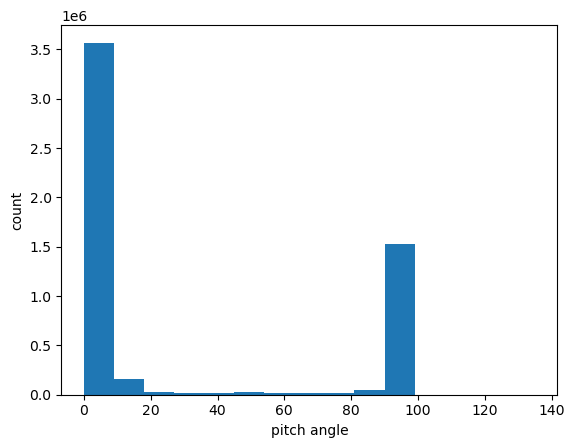

In [7]:
plt.hist(yg_merged["Rotor\nPitch 1 Angle\n[deg]"], bins=15)
plt.xlabel("pitch angle")
plt.ylabel("count")

In [8]:
yg_merged["Date"] = pd.to_datetime(yg_merged["Date"])

In [9]:
combined_data = pd.merge(yg_merged, yg_train_x,on=["Date", "turbine_id"], how="right")
combined_data.rename(columns={"Rotor\nPitch 1 Angle\n[deg]": "state"},inplace =True )

In [10]:
combined_data.loc[:,["wind_speed",'state']]

,wind_speed,state
0,5.556939,90.0
1,4.866656,90.0
2,4.622301,90.0
3,4.609023,90.0
4,4.786076,90.0
...,...,...
917065,3.371726,0.0
917066,3.109348,0.0
917067,3.402199,90.0
917068,3.751137,90.0


Text(0, 0.5, 'pitch angle')

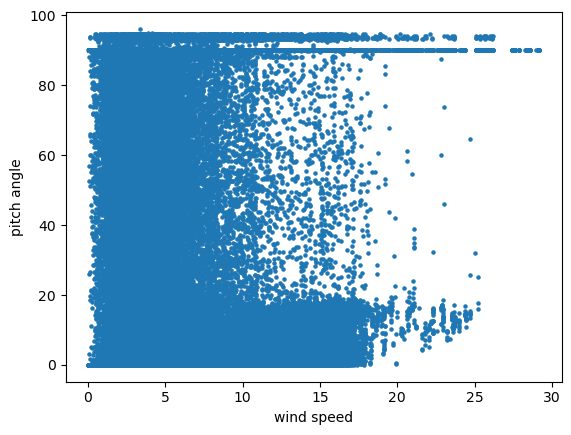

In [11]:
plt.scatter(combined_data["wind_speed"], combined_data["state"],s=5)
plt.xlabel("wind speed")
plt.ylabel("pitch angle")

In [12]:
binary_data = combined_data[-combined_data['state'].isna()]
binary_data['binary_state'] = 1*(binary_data['state']>=45)

/var/folders/tf/02_6lkvd73nbp9k5fyfj80fh0000gn/T/ipykernel_14610/388813723.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  binary_data['binary_state'] = 1*(binary_data['state']>=45)


Text(0, 0.5, 'pitch angle')

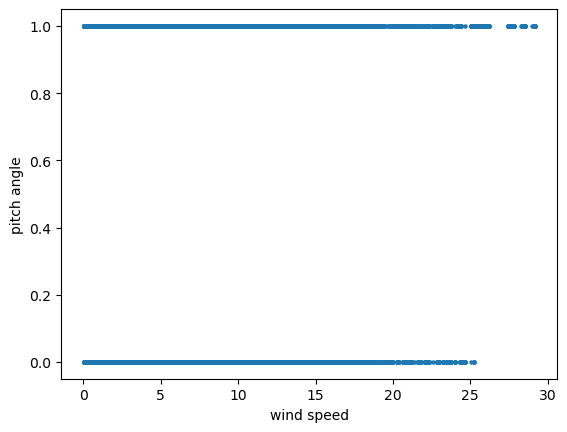

In [13]:
plt.scatter(binary_data["wind_speed"], binary_data["binary_state"],s=5)
plt.xlabel("wind speed")
plt.ylabel("pitch angle")

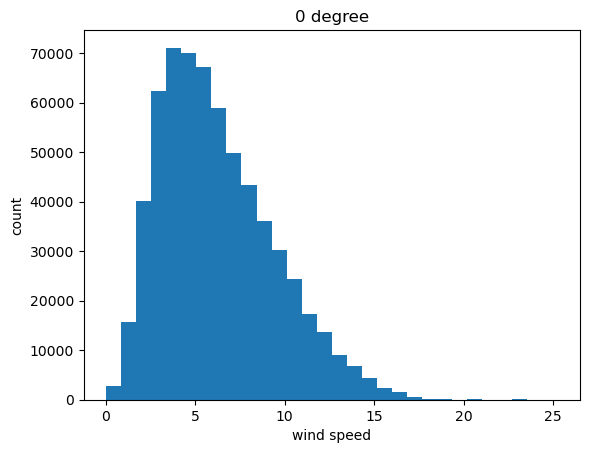

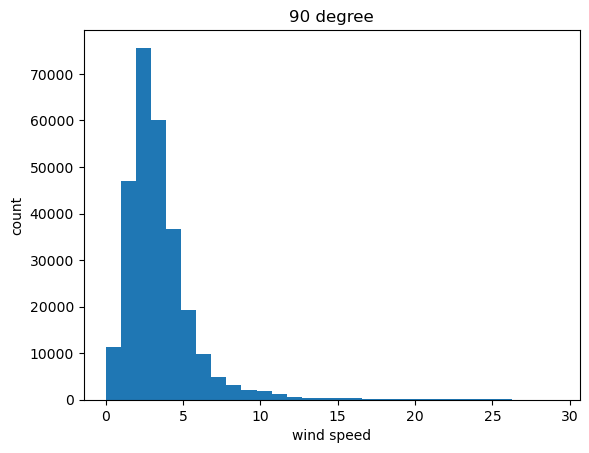

In [14]:
plt.hist(binary_data[binary_data["binary_state"]==0]["wind_speed"],bins=30)
plt.xlabel("wind speed")
plt.ylabel("count")
plt.title("0 degree")
plt.show()

plt.hist(binary_data[binary_data["binary_state"]==1]["wind_speed"],bins=30)
plt.xlabel("wind speed")
plt.ylabel("count")
plt.title("90 degree")
plt.show()

Text(0.5, 1.0, '90 degree')

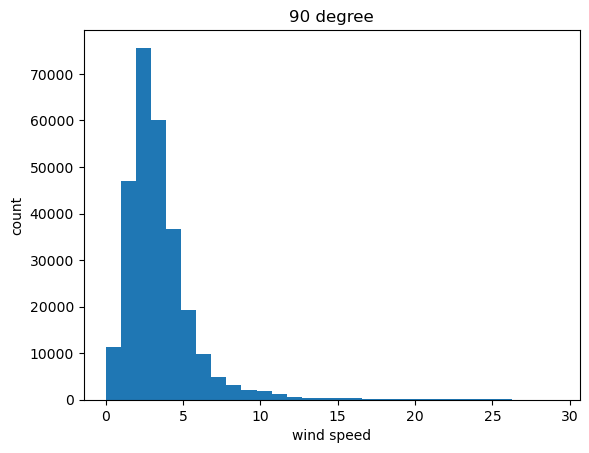

In [15]:
plt.hist(binary_data[binary_data["binary_state"]==1]["wind_speed"],bins=30)
plt.xlabel("wind speed")
plt.ylabel("count")
plt.title("90 degree")

### Preliminary Modeling

### Taking account of Binary state 0

In [30]:
from scipy.stats import boxcox
from scipy.stats import norm
import scipy.stats as stats

# P(X|m=0)
transformed_data, lambd=boxcox(np.array(binary_data[binary_data['binary_state']==0]['wind_speed']))
mean_val=np.mean(transformed_data)
var_val=np.var(transformed_data)
tot_trans_data=(combined_data['wind_speed']**lambd-1)/lambd

p=norm.pdf(tot_trans_data,loc=mean_val, scale=np.sqrt(var_val))

# P(m=0)
q=sum(binary_data['binary_state']==0)/len(binary_data)

# P(X)
transformed_data2, lambd2=boxcox(np.array(binary_data['wind_speed']))
mean_val2=np.mean(transformed_data2)
var_val2=np.var(transformed_data2)
tot_trans_data2=(combined_data['wind_speed']**lambd2-1)/lambd2

r = norm.pdf(tot_trans_data2,loc=mean_val2,scale=np.sqrt(var_val2))

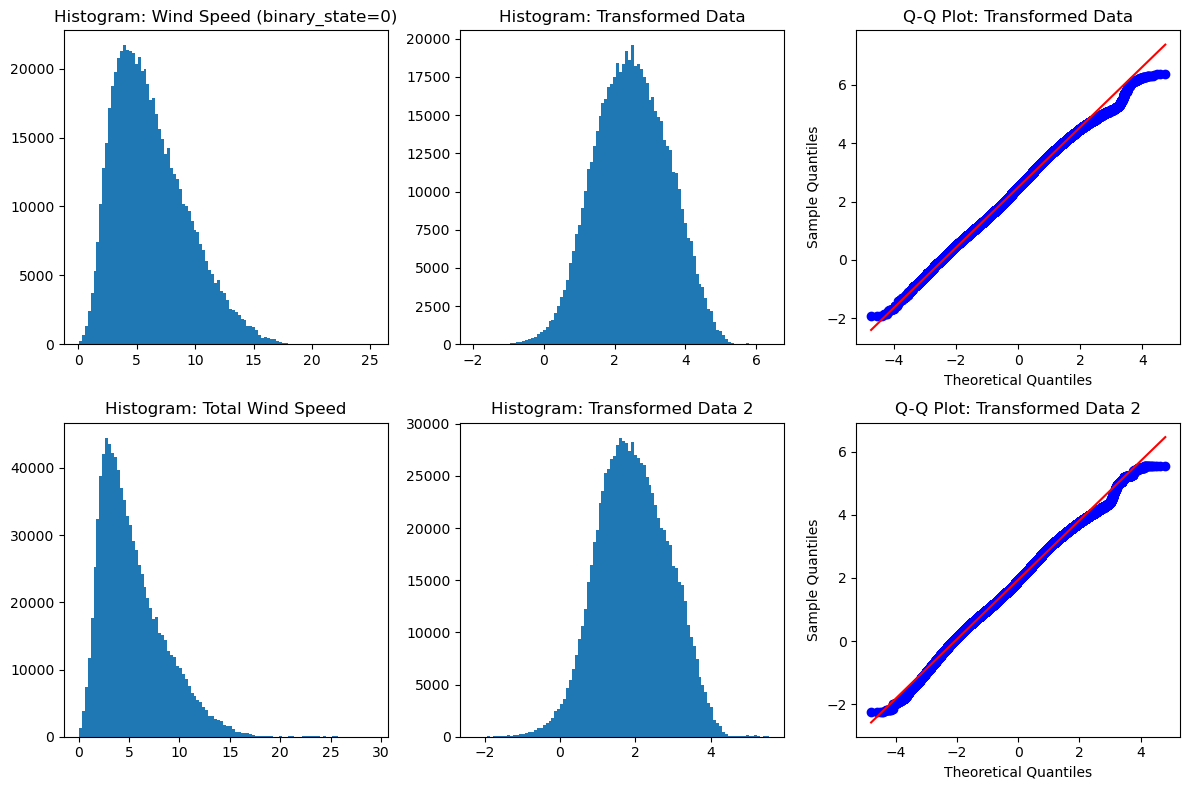

In [40]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

# X|m=0
axes[0, 0].hist(np.array(binary_data[binary_data['binary_state'] == 0]['wind_speed']), bins=100)
axes[0, 0].set_title("Histogram: Wind Speed (binary_state=0)")

# transformed hist
axes[0, 1].hist(transformed_data, bins=100)
axes[0, 1].set_title("Histogram: Transformed Data")

# qq plot check
stats.probplot(transformed_data, dist="norm", plot=axes[0, 2])
axes[0, 2].set_title("Q-Q Plot: Transformed Data")
axes[0, 2].set_xlabel("Theoretical Quantiles")
axes[0, 2].set_ylabel("Sample Quantiles")

# X
axes[1, 0].hist(np.array(combined_data['wind_speed']), bins=100)
axes[1, 0].set_title("Histogram: Total Wind Speed")

# transformed hist2
axes[1, 1].hist(transformed_data2, bins=100)
axes[1, 1].set_title("Histogram: Transformed Data 2")

# qq plot check2
stats.probplot(transformed_data2, dist="norm", plot=axes[1, 2])
axes[1, 2].set_title("Q-Q Plot: Transformed Data 2")
axes[1, 2].set_xlabel("Theoretical Quantiles")
axes[1, 2].set_ylabel("Sample Quantiles")

plt.tight_layout()
plt.show()

In [35]:
combined_data['proba_0'] = p*q/r
combined_data['no_c_with_proba'] = combined_data['proba_0'] * combined_data['without_c']

In [21]:
def train_y_manipulate(train_y, train_date, windfarm): # name of the windfarm 영광풍력 or 경주풍력
    data_return=train_y[train_y['plant_name'] == windfarm]
    data_return['end_datetime']=pd.to_datetime(data_return['end_datetime'])
    data_return=data_return[data_return['end_datetime'].isin(train_date)]

    return data_return    

In [22]:
train_y= pd.read_csv(TRAINING_PATH)
yg_train_date=yg_train_x[yg_train_x['turbine_id']=='WTG01'].index
yg_train_y = train_y_manipulate(train_y, yg_train_date, "영광풍력") 

/var/folders/tf/02_6lkvd73nbp9k5fyfj80fh0000gn/T/ipykernel_14610/1882053878.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_return['end_datetime']=pd.to_datetime(data_return['end_datetime'])


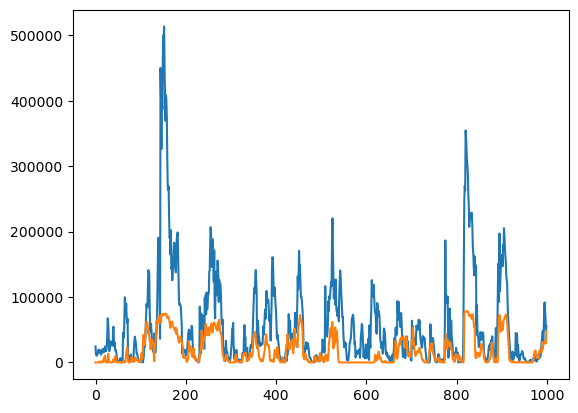

In [23]:
plt.plot(np.array(combined_data.groupby('Date')['no_c_with_proba'].sum())[:1000])
plt.plot(np.array(yg_train_y['energy_kwh'])[:1000])

### Scaling data

#### idea on diff scaling

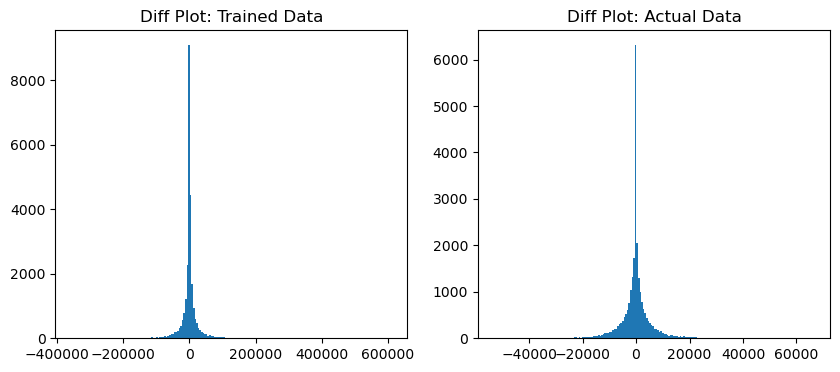

In [59]:
from scipy.stats import laplace
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import beta

fig, axes = plt.subplots(1,2, figsize=(10,4))

axes[0].hist(np.array(combined_data.groupby('Date')['no_c_with_proba'].sum().diff(1)),bins=200)
axes[0].set_title("Diff Plot: Trained Data")

axes[1].hist(np.array(yg_train_y['energy_kwh'].diff(1)),bins=200)
axes[1].set_title("Diff Plot: Actual Data")

plt.tight_layout
plt.show()  


#### diff scaling

In [54]:
sample_diff=combined_data.groupby('Date')['no_c_with_proba'].sum().diff(1)[1:]
real_diff=yg_train_y['energy_kwh'].diff(1)[1:]
loc1, scale1 = laplace.fit(sample_diff)
loc2, scale2 = laplace.fit(real_diff)

sample_diff=loc2+(sample_diff-loc1)*(scale2/scale1)
scaled_diff=sample_diff-np.mean(sample_diff)
adjust_cumsum=np.cumsum(np.insert(scaled_diff,0,np.array(combined_data.groupby('Date')['no_c_with_proba'].sum())[0]))


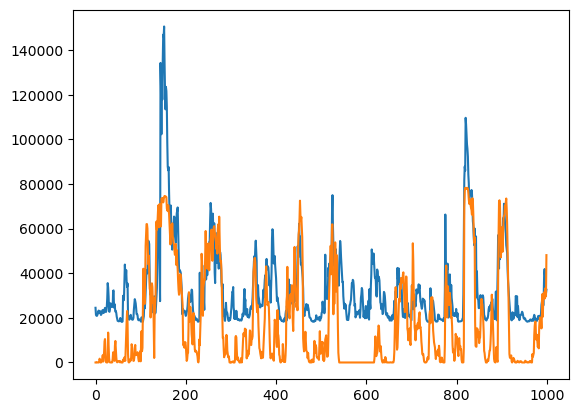

In [55]:
plt.plot(np.array(adjust_cumsum[:1000]))
plt.plot(np.array(yg_train_y['energy_kwh'][:1000]))

#### selecting distribution for dist scaling

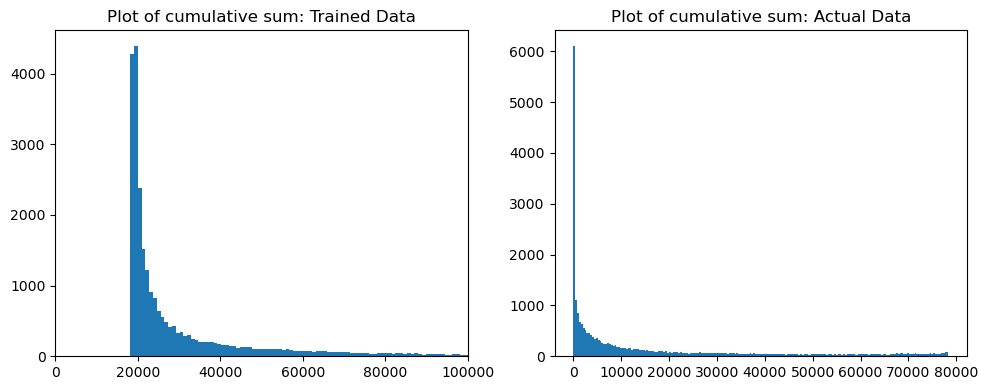

In [91]:
fig, axes = plt.subplots(1,2, figsize=(10,4))

axes[0].hist(adjust_cumsum,bins=200)
axes[0].set_xlim(0,100000)
axes[0].set_title("Plot of cumulative sum: Trained Data")
axes[1].hist(np.array(yg_train_y['energy_kwh']),bins=200)
axes[1].set_title("Plot of cumulative sum: Actual Data")

plt.tight_layout()
plt.show()

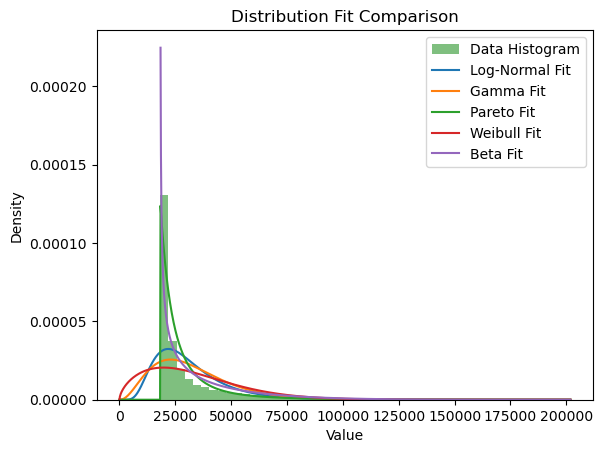

In [92]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import lognorm, gamma, pareto, weibull_min, beta

# 예제 데이터 생성 또는 실제 데이터 로드
data = adjust_cumsum  # 여기에 실제 데이터 삽입

# 각 분포에 대해 피팅 수행 및 시각화
plt.hist(data, bins=50, density=True, alpha=0.5, color='g', label="Data Histogram")

# 1. 로그 정규 분포 피팅
shape, loc, scale = lognorm.fit(data, floc=0)
x = np.linspace(0.1, max(data), 1000)
plt.plot(x, lognorm.pdf(x, shape, loc=loc, scale=scale), label="Log-Normal Fit")

# 2. 감마 분포 피팅
shape, loc, scale = gamma.fit(data, floc=0)
plt.plot(x, gamma.pdf(x, shape, loc=loc, scale=scale), label="Gamma Fit")

# 3. 파레토 분포 피팅
b, loc, scale = pareto.fit(data, floc=0)
plt.plot(x, pareto.pdf(x, b, loc=loc, scale=scale), label="Pareto Fit")

# 4. 웨이블 분포 피팅
c, loc, scale = weibull_min.fit(data, floc=0)
plt.plot(x, weibull_min.pdf(x, c, loc=loc, scale=scale), label="Weibull Fit")

# 데이터가 [0, 1] 범위가 아닌 경우 Beta 분포를 위해 스케일 조정
data_scaled = (data - np.min(data)) / (np.max(data) - np.min(data))
data_scaled=np.clip(data_scaled,1e-6,1-(1e-6))

# 5. 베타 분포 피팅
a, b, loc, scale = beta.fit(data_scaled, floc=0, fscale=1)  # Scale fixed to [0, 1]
x_beta_scaled = np.linspace(0, 1, 1000)
x_beta_original = x_beta_scaled * (np.max(data) - np.min(data)) + np.min(data)
beta_pdf_scaled = beta.pdf(x_beta_scaled, a, b, loc=loc, scale=scale)
beta_pdf_original = beta_pdf_scaled / (np.max(data) - np.min(data))  # Scale density back

# Plot the Beta distribution in the original scale
plt.plot(x_beta_original, beta_pdf_original, label="Beta Fit")

# 그래프 설정
plt.xlabel("Value")
plt.ylabel("Density")
plt.title("Distribution Fit Comparison")
plt.legend()
plt.show()

#### beta-dist scaling

In [86]:
scaler = MinMaxScaler(feature_range=(0,1))

data1_scaled = scaler.fit_transform(adjust_cumsum.reshape(-1,1)).flatten()
data1_scaled=np.clip(data1_scaled,1e-6,1-(1e-6))
a1,b1,loc1,scale1=beta.fit(data1_scaled,floc=0,fscale=1)

data2_scaled=scaler.fit_transform(np.array(yg_train_y['energy_kwh']).reshape(-1,1)).flatten()
data2_scaled=np.clip(data2_scaled,1e-6,1-(1e-6))
a2,b2,loc2,scale2=beta.fit(data2_scaled,floc=0,fscale=1)

x_cdf=beta.cdf(data1_scaled,a1,b1)
converted=beta.ppf(x_cdf,a2,b2)
final_result=converted *(max(yg_train_y['energy_kwh'])-min(yg_train_y['energy_kwh']))+min(yg_train_y['energy_kwh'])

pred_y=pd.DataFrame({
"predict_energy_kwh":final_result
})


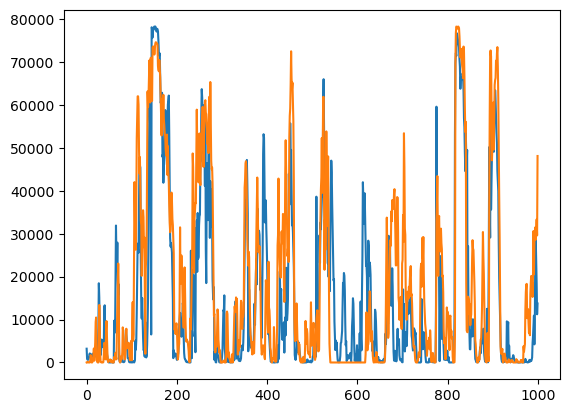

In [87]:
plt.plot(np.array(pred_y)[:1000])
plt.plot(np.array(yg_train_y['energy_kwh'])[:1000])